# Portland Data Science Group Meetup
## Applied Data Science — Portland-Area Traffic Accidents (7/8/2018-7/29/2018)

### Week 1
-  Data source (http://dive-into.info/).
-  Traffic accidents in Clackmas, Washington, Multnomah, and Marion from 2012 to 2015 where data from the first three counties are used to focus on Portland area.
-  Use data to predict 2016 situation.
-  Focus on geospatial analysis in this project.

In [197]:
import pandas as pd

counties = ['Clackamas','Washington', 'Multnomah']
datdir = 'Data'
ctydfs = []

for county in counties:
    filename = "data/" + county + ".csv"
    ctydfs.append(pd.read_csv(filename, low_memory=False))

# combine all of the counties into a single DataFrame
df = pd.concat(ctydfs)

print(str(df.shape[0]), " total rows over " + str(len(counties)) + " counties")

525219  total rows over 3 counties


In [198]:
#split the data by record type and cut the empty columns
crashes = df.loc[df['Record Type'] == 1]
crashes = crashes.dropna(axis='columns', how='all')

# not planning to use the other two record types in this notebook
# but we will create DataFrames for them anyway
df_type2 = df.loc[df['Record Type'] == 2]
df_type2 = df_type2.dropna(axis='columns', how='all')

df_type3 = df.loc[df['Record Type'] == 3]
df_type3 = df_type3.dropna(axis='columns', how='all')

# crashes.head(n=5)

In [199]:
crahses = crashes.reset_index(inplace=True, drop=True)
# convert lon/lat degree-minute-second to decimal degrees
crashes['Longitude Decimal'] = crashes['Longitude Degrees'] + crashes['Longitude Minutes']/60 +\
                               crashes['Longitude Seconds']/3600
crashes['Latitude Decimal'] = crashes['Latitude Degrees'] + crashes['Latitude Minutes']/60 +\
                              crashes['Latitude Seconds']/3600
# drop degree-minute-second columns
crashes.drop(columns=['Longitude Degrees', 'Longitude Minutes', 'Longitude Seconds',
                      'Latitude Degrees', 'Latitude Minutes', 'Latitude Seconds'], inplace=True)


In [200]:
crashes['Crash Month'] = crashes['Crash Month'].astype(int)
crashes['Crash Day'] = crashes['Crash Day'].astype(int)
crashes['Crash Year'] = crashes['Crash Year'].astype(int)

import calendar
crashes['Crash Month'] = crashes['Crash Month'].apply(lambda x: calendar.month_abbr[x])

In [201]:
# interpret county name
county_dict = {3:'Clackmas', 26:'Multnomah', 34:'Washington'}
crashes['County'] = crashes['County Code'].apply(lambda x: county_dict[x])
crashes['County'].value_counts()

Multnomah     54208
Washington    28296
Clackmas      18615
Name: County, dtype: int64

In [203]:
# crashes by year
# crashes['Crash Year'].value_counts()

# crashes by year and county
crashes_freq = crashes.groupby(['County', 'Crash Year']).size().to_frame()
crashes_freq.rename(index=str, columns={0: 'Crash Number'}, inplace=True)
crashes_freq = crashes_freq.reset_index(level='County')
# crashes_freq.set_index('Crash Year', inplace=True)
print(crashes_freq)

Clackmas_freq = crashes_freq.loc[crashes_freq['County'] == 'Clackmas']
Multnomah_freq = crashes_freq.loc[crashes_freq['County'] == 'Multnomah']
Washington_freq = crashes_freq.loc[crashes_freq['County'] == 'Washington']

                County  Crash Number
Crash Year                          
2012          Clackmas          4461
2013          Clackmas          4410
2014          Clackmas          4686
2015          Clackmas          5058
2012         Multnomah         13700
2013         Multnomah         13158
2014         Multnomah         13260
2015         Multnomah         14090
2012        Washington          6700
2013        Washington          6934
2014        Washington          7154
2015        Washington          7508


<IPython.core.display.Javascript object>


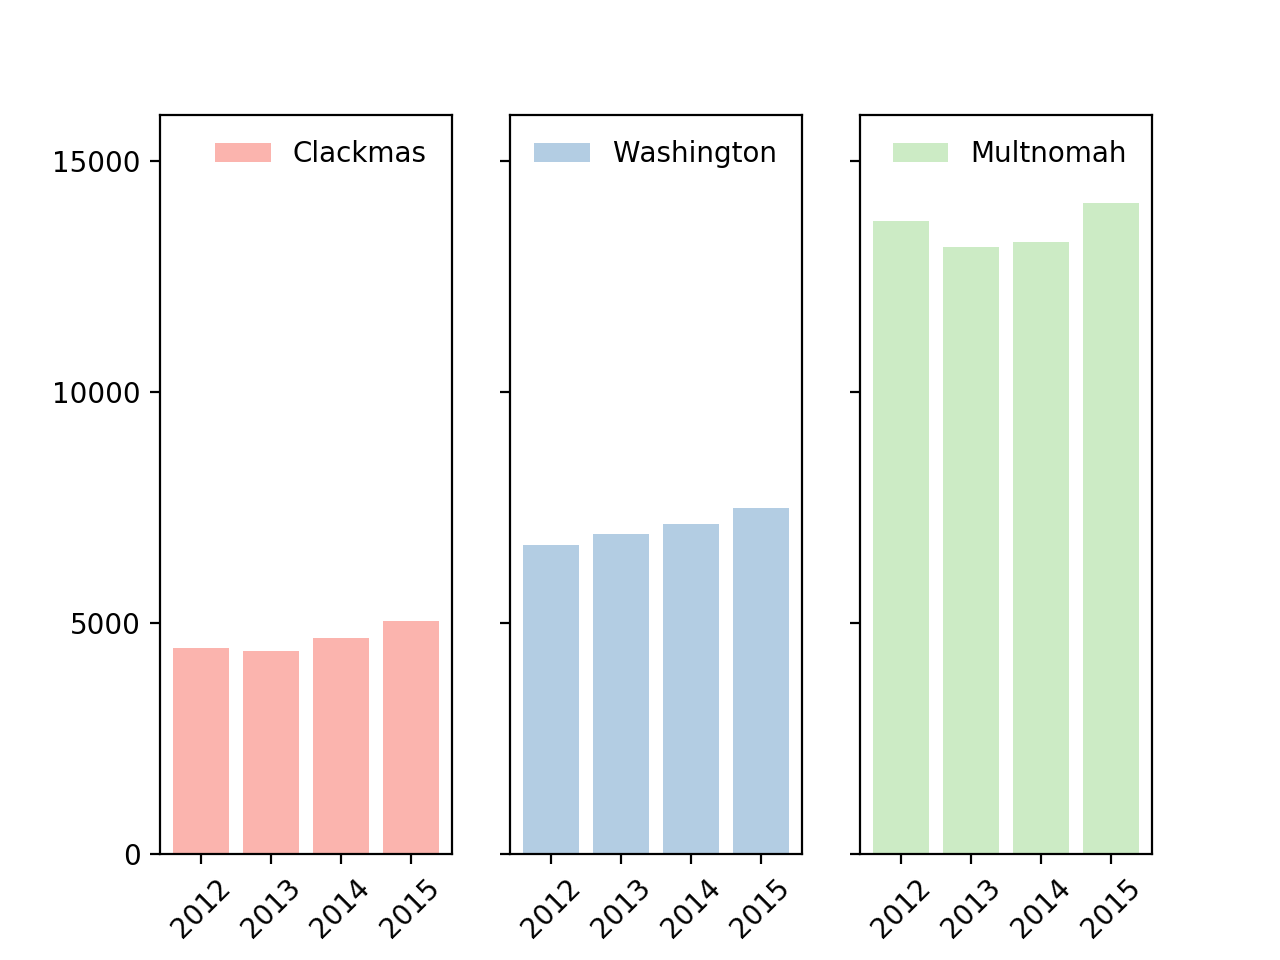

In [204]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

color1, color2, color3 = '#fbb4ae', '#b3cde3', '#ccebc5'
yticks = np.arange(0, 16000, 5000)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.bar(Clackmas_freq.index, Clackmas_freq['Crash Number'], color=color1, align='center', label='Clackmas') 
ax2.bar(Washington_freq.index, Washington_freq['Crash Number'], color=color2, align='center', label='Washington')
ax3.bar(Multnomath_freq.index, Multnomath_freq['Crash Number'], color=color3, align='center', label='Multnomah')

for ax in [ax1, ax2, ax3]:
    ax.legend(frameon=False)
    ax.set_ylim(0, 16000)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)
    for item in ax.xaxis.get_ticklabels():
        item.set_rotation(45) 


### Shapefile
Shapefile from City of Portland. Currently two files are extracted. 
-  Portland neighborhood boundaries (https://gis-pdx.opendata.arcgis.com/datasets/neighborhood-boundaries). 
-  Oregon county boundaries (https://gis-pdx.opendata.arcgis.com/datasets/4577bb8a8b5147fc86026c3c692ec8fa_9?geometry=-126.354%2C44.859%2C-118.872%2C46.206). 

These files will later be used for data visualization (e.g., heat map).

In [183]:
# portland neighbourhood
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
import fiona
from shapely.geometry import Polygon, MultiPolygon, shape

portland_shapefile = fiona.open("Data/External_data/Neighborhood_Boundaries/Neighborhood_Boundaries.shp")
county_shapefile = fiona.open("Data/External_data/County_Boundaries/County_Boundaries.shp")

In [186]:
# Display some information
print('Total neighborhood number in Portland: \n', len(portland_shapefile), '\n')
print('Shapefile attributes include: \n', portland_shapefile.schema, '\n')

# Name of Portland neighborhoods
print('Name of Portland neighborhoods: ')
for feat in portland_shapefile:
     print(feat['properties']['MAPLABEL'])
        

Total neighborhood number in Portland: 
 130 

Shapefile attributes include: 
 {'properties': OrderedDict([('OBJECTID', 'int:10'), ('NAME', 'str:80'), ('COMMPLAN', 'str:80'), ('SHARED', 'str:80'), ('COALIT', 'str:80'), ('HORZ_VERT', 'str:80'), ('Shape_Leng', 'float:24.15'), ('MAPLABEL', 'str:80')]), 'geometry': 'Polygon'} 

Name of Portland neighborhoods: 
St. Johns
Hayden Island Neighborhood Network
Linnton
Forest Park/Linnton
Kenton
Forest Park
Bridgeton
East Columbia
Mc Unclaimed #2
Cathedral Park
Sunderland Association Of Neighbors
Portsmouth
University Park
MC Unclaimed #14
Piedmont
Woodlawn
Cully Association Of Neighbors
Arbor Lodge
Overlook
Concordia
Parkrose
Sumner Association Of Neighbors
Argay Terrace
Humboldt
King
Vernon
Wilkes Community Group
Beaumont-Wilshire
Sabin Community Association
Alameda
Boise
Northwest Heights
Roseway
Madison South
Argay/Wilkes Community Group
Boise/Eliot
Eliot
Irvington Community Association
Sabin Community Assn./Irvington Community Assn.
Alameda/

In [192]:
print('Total county number in Oregon: \n', len(county_shapefile), '\n')
print('Shapefile attributes include: \n', county_shapefile.schema, '\n')

# Name of Portland neighborhoods
print('Name of Oregon counties: ')
for feat in county_shapefile:
     print(feat['properties']['COUNTY'])

Total county number in Oregon: 
 11 

Shapefile attributes include: 
 {'properties': OrderedDict([('OBJECTID', 'int:10'), ('COUNTY_NO', 'int:10'), ('COUNTY', 'str:80'), ('Shape_Leng', 'float:24.15'), ('AREA', 'float:24.15')]), 'geometry': 'Polygon'} 

Name of Oregon counties: 
Yamhill
Polk
Clackamas
Hood River
Columbia
Skamania
Cowlitz
Clark
Marion
Multnomah
Washington


<IPython.core.display.Javascript object>


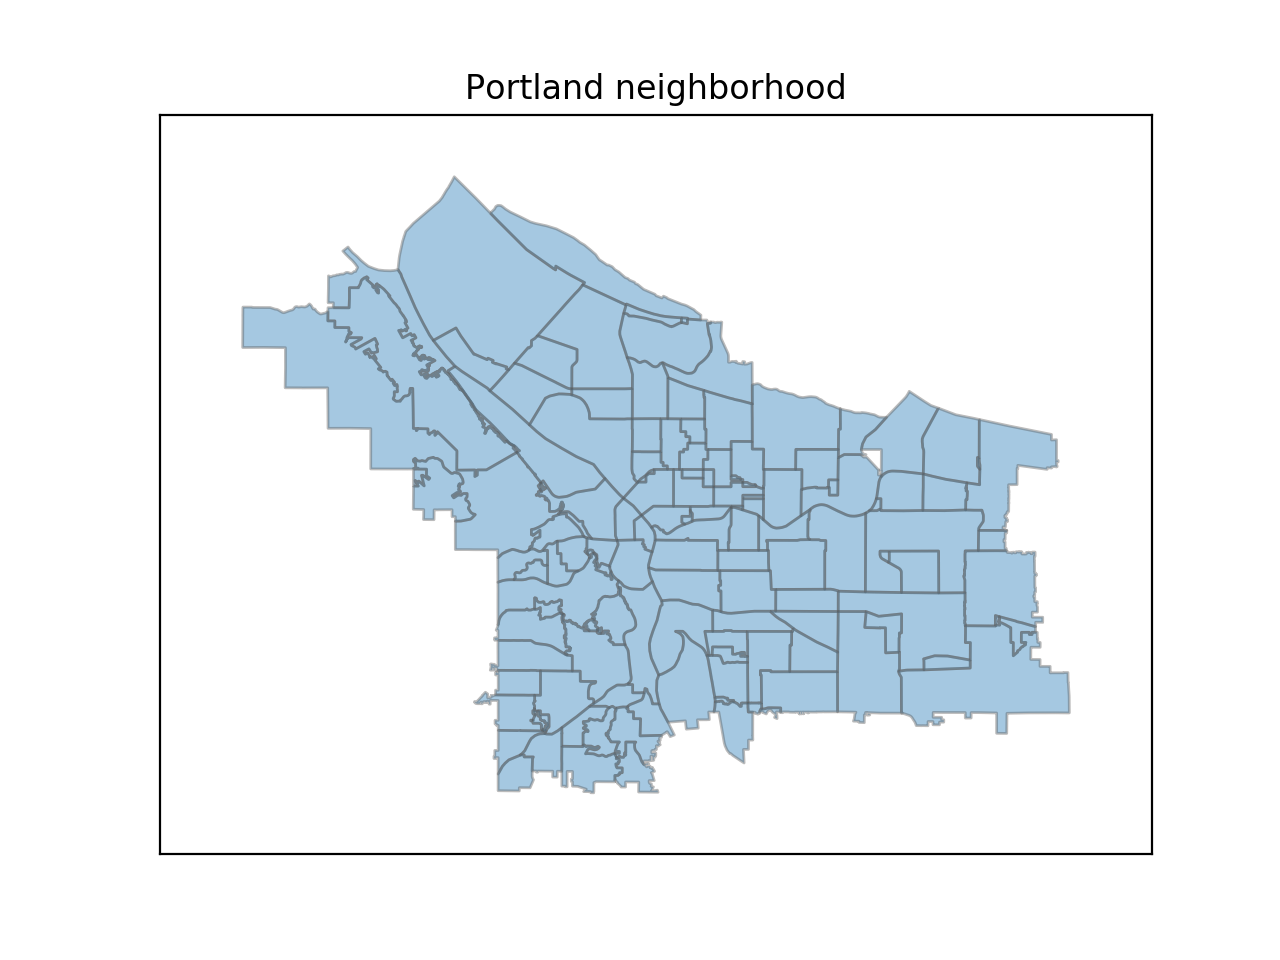

In [187]:
# Display Portland neighborhoods
mp = MultiPolygon([shape(pol['geometry']) for pol in portland_shapefile])
cm = plt.get_cmap('RdBu')
num_colours = len(mp)

fig, ax = plt.subplots()
minx, miny, maxx, maxy = mp.bounds
w, h = maxx - minx, maxy - miny
# ax.set_xlim(minx - 0.2 * w, maxx + 0.2 * w)
# ax.set_ylim(miny - 0.2 * h, maxy + 0.2 * h)
ax.set_xlim(minx - 0.1 * w, maxx + 0.1 * w)
ax.set_ylim(miny - 0.1 * h, maxy + 0.1 * h)

patches = []
for idx, p in enumerate(mp):
#     colour = cm(1. * idx / num_colours)
#     patches.append(PolygonPatch(p, fc=colour, ec='#555555', alpha=1., zorder=1))
    patches.append(PolygonPatch(p, ec='#555555', alpha=.4, zorder=1))
ax.add_collection(PatchCollection(patches, match_original=True))
ax.set_xticks([])
ax.set_yticks([])
plt.title("Portland neighborhood")
plt.show()

<IPython.core.display.Javascript object>


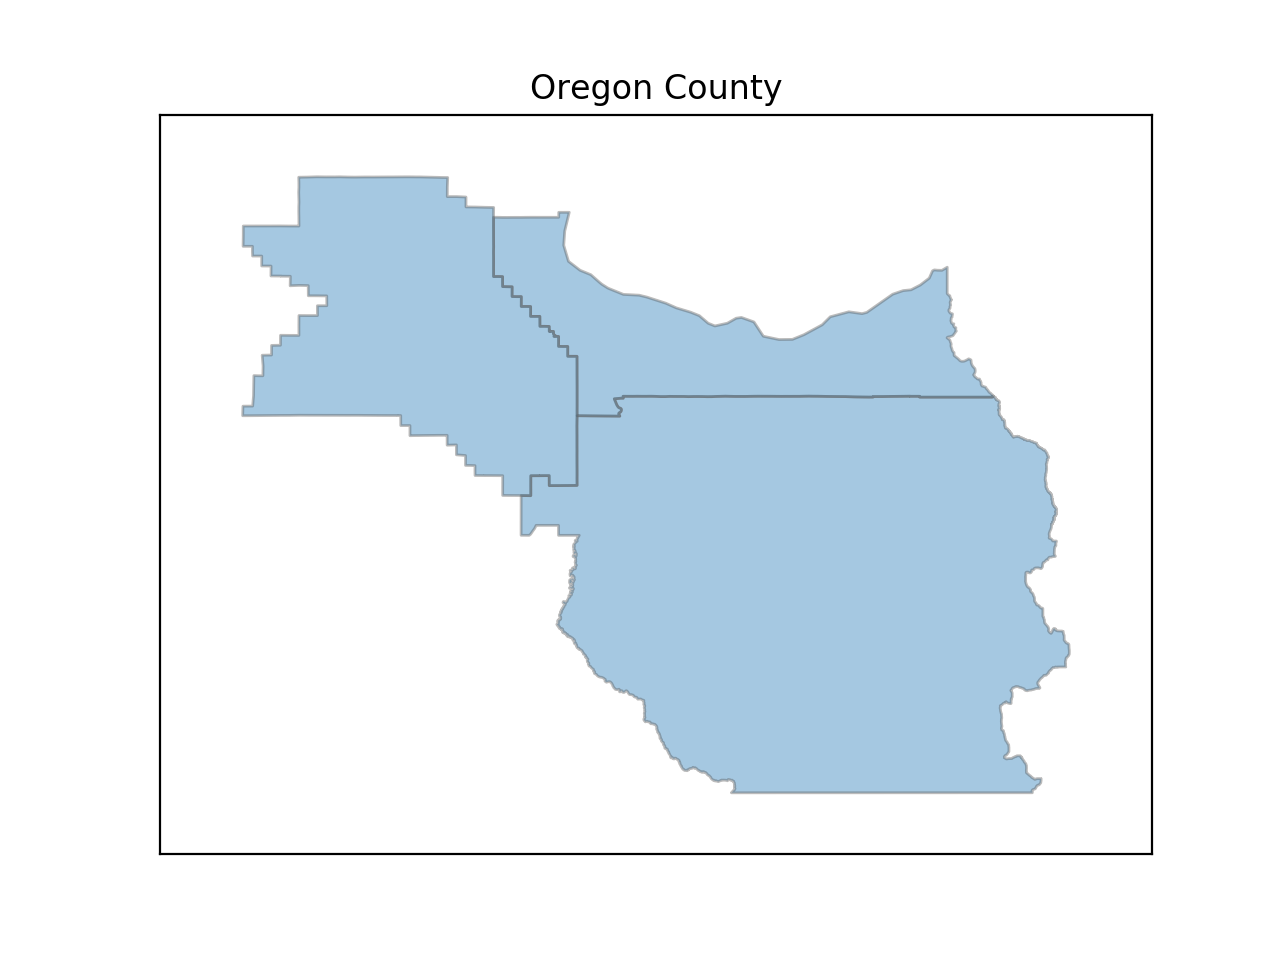

In [196]:
# Display ountiess
select_county = ['Clackamas', 'Washington', 'Multnomah']
mp_county = MultiPolygon([shape(pol['geometry']) for pol in county_shapefile if pol['properties']['COUNTY'] in select_county])
# cm = plt.get_cmap('RdBu')
# num_colours = len(mp)

fig, ax = plt.subplots()
minx, miny, maxx, maxy = mp_county.bounds
w, h = maxx - minx, maxy - miny
# ax.set_xlim(minx - 0.2 * w, maxx + 0.2 * w)
# ax.set_ylim(miny - 0.2 * h, maxy + 0.2 * h)
ax.set_xlim(minx - 0.1 * w, maxx + 0.1 * w)
ax.set_ylim(miny - 0.1 * h, maxy + 0.1 * h)

patches = []
for idx, p in enumerate(mp_county):
#     colour = cm(1. * idx / num_colours)
#     patches.append(PolygonPatch(p, fc=colour, ec='#555555', alpha=1., zorder=1))
    patches.append(PolygonPatch(p, ec='#555555', alpha=.4, zorder=1))
ax.add_collection(PatchCollection(patches, match_original=True))
ax.set_xticks([])
ax.set_yticks([])
plt.title("Oregon County")
plt.show()